# Домашнее задание. Титаник
В этом домашнем задании вам предлагается решить задачу предсказания выживших пассажиров Титаника. Эту задачу машинного обучения рано или поздно решает, наверное, любой, кто обучается анализу данных. Информация о датасете доступна по <a href=https://www.kaggle.com/c/titanic.>ссылке</a>.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных

Загрузим датасет Titanic из приложенных файлов. В первом файле находится информация о пассажирах, во втором -- информация о том, выжил пассажир или нет.

Если вы запускаете ноутбук на Google Colab, самым простым способом загрузить данные в ноутбук будет примонтировать к Colab ваш Google Drive. Для этого сначала положите в свою корневую директорию Google Drive  файлы, приложенные к этому ноутбуку, а затем выполните три закоментированные строчки в клетке ниже. <a href=https://www.machinelearningmastery.ru/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166/>Подробная инструкция по работе с Google Drive + Google Colab</a>

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#data = pd.read_csv('/content/gdrive/My Drive/titanic_data.csv, index_col='PassengerId')

#Если запускаете ноутбук локально:
data = pd.read_csv('titanic_data.csv')

In [3]:
basic_features = data.columns

Y = pd.read_csv('titanic_surv.csv')
#Y.index = data.index

print(f'Всего {len(data)} пассажиров в выборке')
data.head()

Всего 891 пассажиров в выборке


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [5]:
data = data.join(Y)
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Исследование датасета

### Задание 1 (1 балл)
Опишите датасет. Сколько в нём мужчин, сколько женщин? Посчитайте распределение по классам пассажиров. Используйте функцию ``pd.Series.value_counts``. <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html>Пример использования</a>

Посчитайте долю выживших мужчин к общему количеству мужчин, а также женщин к общему количеству женщин. Сделайте выводы. 
Проведите схожую аналитику по возрасту выживших и по классу выживших. 

Вам поможет функция ``plt.hist()``. <a href=https://matplotlib.org/3.3.1/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py> Пример использования </a> 

### Распределение числовых признаков

Сперва посмотрим на распределения числовых признаков. 
На первых этапах это поможет лучше понять репрезентативность обучающей выборки.

In [6]:
data.iloc[:, 1:].describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


Описание численных признаков:
- Количество рассматриваемых пассажиров - 891
- Большинство пассажиров (>75%) не путешествовали с родителями или детьми
- Почти у 30% пассажиров на борту были братья, сестры и / или супруги
- Стоимость проезда значительно различалась: немногие пассажиры (<1%) платили до 512 долларов
- Небольшое количество пожилых пассажиров (<1%) в возрасте 65-80 лет

#### Посмотрим на распределение по классам пассажиров

In [7]:
data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


* Видим, что мы получили существенную корреляцию (>0.5) между Pclass = 1 и меткой Survived

#### Посчитаем долю выживших мужчин к общему количеству мужчин, а также женщин к общему количеству женщин.

In [9]:
data[['Sex', 'Survived']].groupby(['Sex']).agg({'Survived': 'mean'}).sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


* Видим, что женщины Sex = 'female' имеют высокий процент выживаемости ~74%

Для наглядности визуализируем распределение по полу. 

(-1, 2)

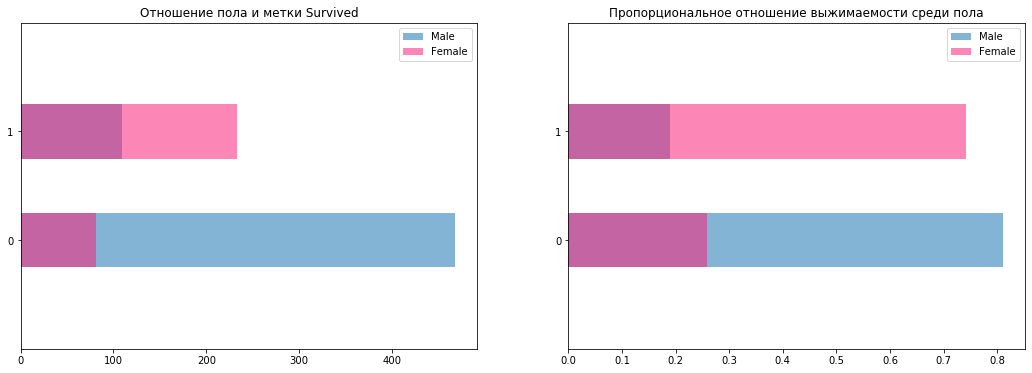

In [10]:
fig = plt.figure(figsize=(18,6))

data_male = data.Survived[data.Sex == 'male'].value_counts().sort_index()
data_female = data.Survived[data.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
data_male.plot(kind='barh',label='Male', alpha=0.55)
data_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Отношение пола и метки Survived"); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

ax2 = fig.add_subplot(122)
(data_male/float(data_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(data_female/float(data_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Пропорциональное отношение выжимаемости среди пола"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)

#### Посмотрим на возраст пассажиров

Средний возраст - 28.0


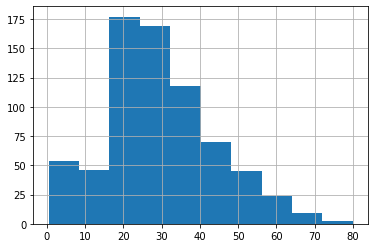

In [11]:
data.Age.hist()
print(f"Средний возраст - {round(data.Age.median())}")

In [12]:
data[['Age', 'Survived']].groupby(['Age']).agg({'Survived': 'count'}).sort_values(by='Survived', ascending=False).head()

,Survived
Age,
24.0,30
22.0,27
18.0,26
30.0,25
28.0,25


#### Дополнительно проверим корреляцию с сопутствующиими пассажирами (SibSp) и числом родителей/детей на борту (Parch)

In [13]:
data[['SibSp', 'Survived']].groupby(['SibSp']).agg({'Survived': 'mean'}).sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [14]:
data[['Parch', 'Survived']].groupby(['Parch']).agg({'Survived': 'mean'}).sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


* Видим, что для определённых значений корреляция нулевая

In [15]:
data.corrwith(data["Survived"]).drop("Survived")

PassengerId   -0.005007
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

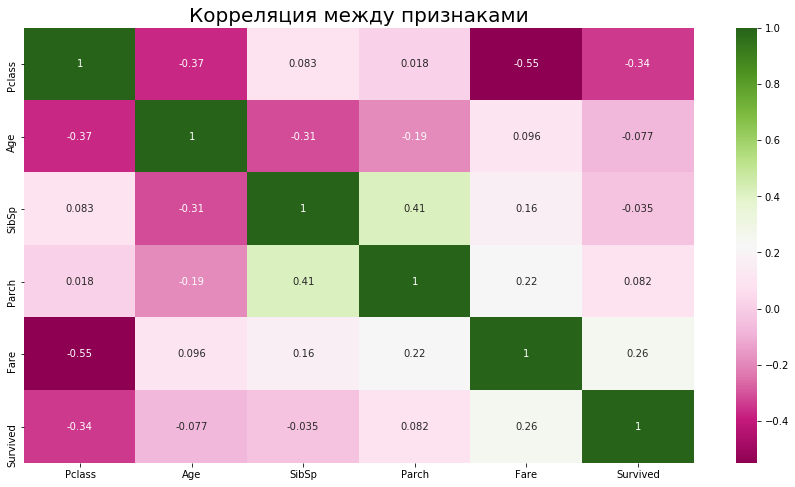

In [16]:
import seaborn as sns

plt.subplots(figsize = (15,8))
sns.heatmap(data[["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]].corr(), annot=True,cmap="PiYG")
plt.title("Корреляция между признаками", fontsize = 20);

## Заполнение пропусков в данных
В данных имеются пропуски в трёх колонках: 

In [17]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Для простоты заполним все пропуски в категориальных колонках новым классом "0", а в числовой колонке Age --- медианным значением. 

In [18]:
data.loc[:, ['Cabin', 'Embarked']] = data.loc[:, ['Cabin', 'Embarked']].fillna('0')
data['Age'] = data['Age'].fillna(data['Age'].median())

## Подготовка плана тестирования

### Задание 2. (0 баллов)
Разделите выборку на обучающее и тестовое множество в соотношении 70:30.

In [19]:
# Данный пункт решено было провести после преобразования признаков

# from sklearn.model_selection import train_test_split

# X = data.drop("Survived", axis=1)
# y = data["Survived"]

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
data_full = data.copy().drop("PassengerId", axis=1)

## Выделение новых признаков
Теперь отложим тестовые данные и приступим к моделированию. Внимательно изучите данные. Можете ли вы выделить признаки, которые не указаны явно в таблице?

### Задание 3 (1 балл)
 Сформируйте по крайней мере один новый признак и объясните ваш выбор. Пример признака сформирован за вас. 

Указания: 
- Пассажиров можно поделить на несколько классов по их именам.
- Различных номеров кают слишком много. Но буквы в номерах кают указывают на их местоположение. (***Этот признак сформирован в примере***)
- Возможно, имеет смысл отделить мальчиков от мужчин. Отделять девочек от женщин может быть не так важно
- Другие идеи для признаков можно почерпнуть на форуме в обсуждении задачи на kaggle.com.

In [22]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0


In [23]:
data['Cabin']

0         0
1       C85
2         0
3      C123
4         0
       ... 
886       0
887     B42
888       0
889    C148
890       0
Name: Cabin, Length: 891, dtype: object

### Рассмотрим подробнее категориальные признаки

In [24]:
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,148,4
top,"Kraeff, Mr. Theodor",male,347082,0,S
freq,1,577,7,687,644


* Уникальных имён в датасете - 891
* Значения каюты (Cabin) имеют дубликаты. Значит, некоторые пассажиры жили в одной каюте
* Порт погрузки (Embarked) имеет три уникальных значения + 1 (класс "0"), которым мы заполнили пропуски
* Билеты часто повторяются

Добавим новый признак в качестве примера

In [25]:
def get_cabin_letter(row):
    return row['Cabin'][0]

data['cabin_type'] = data.apply(get_cabin_letter, axis=1)

In [26]:
data.drop(['Cabin'], axis=1, inplace=True)

### Собственные признаки

Идея для нового признака: можно отказаться от признака "Name" (нам не так важно само имя, как его титульный префикс).

In [27]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(data['Title'], data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Для упрощения можно сделать маппинг между распространёнными титулами и выделить отдельный класс - редкие

In [28]:
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Сразу же преобразуем в порядковые признаки (пусть и далее по задания стоит отдельный блок по преобразованию признаков)

In [29]:
mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

data['Title'] = data['Title'].map(mapping)
data['Title'] = data['Title'].fillna(0)

data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived,cabin_type,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,C,3
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,C,3
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0,1


Исключим признак "Name", так как он нам теперь не потребуется

In [30]:
data.drop(['Name'], axis=1, inplace=True)

Рассмотрим ещё один возможный вариант нового признака.
Создадим новый признак "Family" на основе которого классифицуруем пассажиров на 2 класса - были ли они одни или вместе с семьёй

In [31]:
data['Family'] = data['SibSp'] + data['Parch'] + 1

data[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


#

In [32]:
data['IsAlone'] = 0
data.loc[data['Family'] == 1, 'IsAlone'] = 1

data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Сразу же удалим из датасета теперь уже лишнюю информацию

In [33]:
data.drop(['Parch', 'SibSp', 'Family'], axis=1, inplace=True)
data.head()

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Embarked,Survived,cabin_type,Title,IsAlone
0,1,3,male,22.0,A/5 21171,7.2500,S,0,0,1,0
1,2,1,female,38.0,PC 17599,71.2833,C,1,C,3,0
2,3,3,female,26.0,STON/O2. 3101282,7.9250,S,1,0,2,1
3,4,1,female,35.0,113803,53.1000,S,1,C,3,0
4,5,3,male,35.0,373450,8.0500,S,0,0,1,1


Также сложно выцепить какую-либо полезную информацию с признаков "Ticket".

In [34]:
data.drop(['Ticket'], axis=1, inplace=True)
data.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,cabin_type,Title,IsAlone
0,1,3,male,22.0,7.2500,S,0,0,1,0
1,2,1,female,38.0,71.2833,C,1,C,3,0
2,3,3,female,26.0,7.9250,S,1,0,2,1
3,4,1,female,35.0,53.1000,S,1,C,3,0
4,5,3,male,35.0,8.0500,S,0,0,1,1


Преобразуем метку "Fare" (плата за проезд) в порядковые значения с помощью объединения в группу "FareBand"

In [35]:
data['FareBand'] = pd.qcut(data['Fare'], 4)
data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [36]:
data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[ data['Fare'] > 31, 'Fare'] = 3
data['Fare'] = data['Fare'].astype(int)

data = data.drop(['FareBand'], axis=1)
    
data.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,cabin_type,Title,IsAlone
0,1,3,male,22.0,0,S,0,0,1,0
1,2,1,female,38.0,3,C,1,C,3,0
2,3,3,female,26.0,1,S,1,0,2,1
3,4,1,female,35.0,3,S,1,C,3,0
4,5,3,male,35.0,1,S,0,0,1,1
5,6,3,male,28.0,1,Q,0,0,1,1
6,7,1,male,54.0,3,S,0,E,1,1
7,8,3,male,2.0,2,S,0,0,4,0
8,9,3,female,27.0,1,S,1,0,3,0
9,10,2,female,14.0,2,C,1,0,3,0


#

In [37]:
data.loc[ data['Age'] <= 16, 'Age'] = 0,
data.loc[(data['Age'] > 16) & (data['Age'] <= 26), 'Age'] = 1,
data.loc[(data['Age'] > 26) & (data['Age'] <= 36), 'Age'] = 2,
data.loc[(data['Age'] > 36) & (data['Age'] <= 62), 'Age'] = 3,
data.loc[ data['Age'] > 62, 'Age'] = 4

In [38]:
sex_mapping = {"male": 0, "female": 1}

data['Sex'] = data['Sex'].map(sex_mapping)

In [39]:
# embarked_mapping = {'S':0,'C':1,'Q':2}
# data['Embarked'] =  data['Embarked'].fillna('S')
# data['Embarked'] = data['Embarked'].map(embarked_mapping)

## Кодирование категориальных признаков и обработка данных
Все признаки сейчас делятся на числовые, бинарные, категориальные и текстовые. К текстовым признакам можно отнести имя пассажира, номер билета и номер каюты: значения этих признаков уникальны почти для всех пассажиров, и простого способа использовать их в модели не существует.

### Задание 4 (0 баллов)
Пока используя только изначальные признаки, перекодируйте категориальные признаки функцией ``pd.get_dummies``. Естественно, имена пассажиров и номера билетов и кают кодировать не стоит, поскольку все значения этих признаков уникальные. 

In [40]:
data = pd.get_dummies(data)

data.head()

,PassengerId,Pclass,Sex,Age,Fare,Survived,Title,IsAlone,Embarked_0,Embarked_C,...,Embarked_S,cabin_type_0,cabin_type_A,cabin_type_B,cabin_type_C,cabin_type_D,cabin_type_E,cabin_type_F,cabin_type_G,cabin_type_T
0,1,3,0,1.0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,2,1,1,3.0,3,1,3,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,3,3,1,1.0,1,1,2,1,0,0,...,1,1,0,0,0,0,0,0,0,0
3,4,1,1,2.0,3,1,3,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,5,3,0,2.0,1,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0


## Возврат к подготовке плана тестирования

In [41]:
X = data.drop(["Survived", "PassengerId"], axis=1)
y = Y["Survived"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [42]:
X.isnull().sum()

Pclass          0
Sex             0
Age             0
Fare            0
Title           0
IsAlone         0
Embarked_0      0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
cabin_type_0    0
cabin_type_A    0
cabin_type_B    0
cabin_type_C    0
cabin_type_D    0
cabin_type_E    0
cabin_type_F    0
cabin_type_G    0
cabin_type_T    0
dtype: int64

## Обучение baseline-модели

### Задание 5 (1 балл)

Обучите одну из простых известных вам моделей. Измерьте качество полученной модели на кросс-валидации (используйте только обучающую выборку!)

Так как определённые манипуляции с датасетом уже были произведены, снова загрузим наши данные, сделаем стандартное one-hot кодирование и посмотрим на результат с помощью двух моделей - DecisionTreeClassifier и KNeighborsClassifier.

In [43]:
data_full = pd.get_dummies(data_full)
X_old, y_old = data_full.drop(["Survived"], axis=1), data_full.Survived

In [44]:
clf = DecisionTreeClassifier()
cross_val_score(clf, X_old, y_old).mean()

0.8215742891218379

In [45]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_old, y_old).mean()

0.7059757705103257

Видим, что качество на кросс-валидации существенно отличается у этих двух моделей.

### Задание 6 (1 балл)
Добавьте в модель два новых сгенерированных признака. Если нужно, добавьте признаки, сгенерированные ohe-hot кодированием. Обучите ту же самую модель на расширенном множестве признаков. Улучшилось ли качество предсказания на кросс-валидации?

In [46]:
clf = DecisionTreeClassifier()
cross_val_score(clf, X_train, y_train).mean()

0.7784000000000001

In [47]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train).mean()

0.7944774193548387

Видим, что теперь картина несколько иная. После расширенных и модифицированных признаков (вместо сгенерированных автоматически функцией get_dummies), качество предсказания у _дерева решений_ чуть уменьшилось, но гораздо существеннее качество увеличилось у алгоритма _k-ближайших соседей_

Для примера попробуем обучить модель "RandomForestClassifier" с интуитивным подбором параметров.

In [49]:
clf_rf = RandomForestClassifier(n_estimators=100, 
                                min_samples_leaf=3, 
                                min_samples_split=8, 
                                class_weight='balanced')

clf_rf.fit(X_train, y_train)
pred_proba = clf_rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9197779725387087


Как видно, ситуация заметно улучшилась. Причём теперь с настройками по умолчанию KNeighborsClassifier показывает более выигрышный результат.
Далее проведём более глубокое исследование.

## Дополнительное моделирование
### Задание 7 (2 балла)
Теперь более серьёзно подойдём к моделированию. Попробуйте несколько алгоритмов из тех, что мы проходили в курсе. Вам помогут ноутбуки с линейными алгоритмами и выбором модели. Хотя бы для одного алгоритма проведите подбор оптимального гиперпараметра. 

Рассмотрим следующие модели:

In [54]:
accuracies = {}

In [55]:
clfs = [KNeighborsClassifier(), DecisionTreeClassifier(),
       RandomForestClassifier(), GaussianNB(), SVC(), ExtraTreeClassifier(), LogisticRegression()]

In [56]:
def model_fit():
    for model in clfs:
        score = cross_val_score(model, X_train, y_train)
        print("Score of Model", model, ":", round(np.mean(score)*100,2))

In [57]:
model_fit()

Score of Model KNeighborsClassifier() : 79.45
Score of Model DecisionTreeClassifier() : 77.52
Score of Model RandomForestClassifier() : 79.6
Score of Model GaussianNB() : 65.18
Score of Model SVC() : 78.49
Score of Model ExtraTreeClassifier() : 78.8
Score of Model LogisticRegression() : 78.64


Самые лучшие значения получились у моделей _RandomForestClassifier_, _KNeighborsClassifier_ и _SVC_

Попробуем подобрать гиперпараметры для этих моделей и постараемся получить наилучшую модель с оптимальными из заданных настроек параметрами

#### Подбор гиперпараметров для RandomForestClassifier и SVC

In [58]:
clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': range(10, 171, 10), 'max_depth': range(1, 11, 2), 
             'min_samples_leaf': range(1, 11), 'min_samples_split': range(2, 10, 2)}

grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=3, n_jobs=-1)

grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

best_clf = grid_search_cv_clf.best_estimator_

pred_proba_rf = best_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba_rf[:, 1])

print('roc на test', roc_score)

accuracies["RandomForest"] = roc_score

roc на test 0.9145778556821501


In [59]:
best_clf

RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=110)

В итоге после подбора гиперпараметров с помощью GridSearchCV получили оценку точности чуть хуже интуитивно-подобранных параметров

In [60]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid_search_svm_clf = GridSearchCV(SVC(probability=True), param_grid, scoring='roc_auc', cv=5)

grid_search_svm_clf.fit(X_train, y_train)

best_clf_2 = grid_search_svm_clf.best_estimator_

pred_proba_svm = best_clf_2.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba_svm[:, 1])

print('roc на test', roc_score)

accuracies["SVC"] = roc_score

roc на test 0.8493718959976629


Подбор гиперпараметров для _SVC_ принёс положительный вклад в точности предсказания, пусть и не существенный

Также проведём дополнительный анализ и построим ROC-кривую для KNeighborsClassifier, попробовав получить более интересные показатели

#### Дополнительно исследуем модель _KNeighborsClassifier_

Используем следующие две функции: 
* _search_ - визуализирующая поиск оптимального гиперпараметра модели по сетке. Для этого используем метод GridSearchCV из sklearn.model_selection.
* _plot_roc_curve_ - строит roc-кривую

In [61]:
def search(X, y, model, param_name, grid, draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='deviation area between errors')
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [62]:
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(12,10))
    ra_train = roc_auc_score(y_train, y_train_proba)
    ra_test = roc_auc_score(y_test, y_test_proba)
    
    print(f'Train roc-auc: {ra_train}')
    print(f'Test roc-auc: {ra_test}')
    
    accuracies[model] = ra_test
    
    plt.plot(*roc_curve(y_train, y_train_proba)[:2], label='train roc-curve')
    plt.plot(*roc_curve(y_test, y_test_proba)[:2], label='test roc-curve')

    plt.plot([0,1], [0,1], linestyle='--', color='black')
    plt.grid(True)
    plt.legend()
    plt.show()

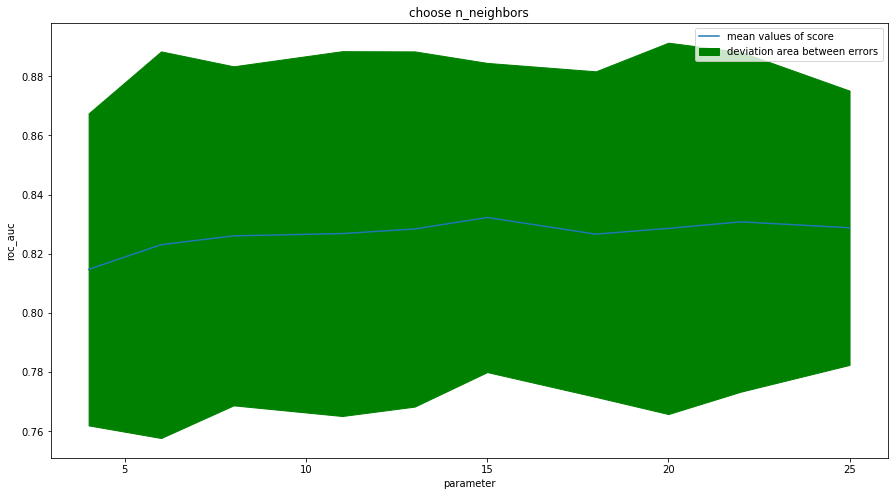

In [63]:
models = [KNeighborsClassifier(n_jobs=-1)]
param_names = ['n_neighbors']
grids = [np.array(np.linspace(4, 25, 10), dtype='int')]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 0.8694879867077676
Test roc-auc: 0.8852468594799883


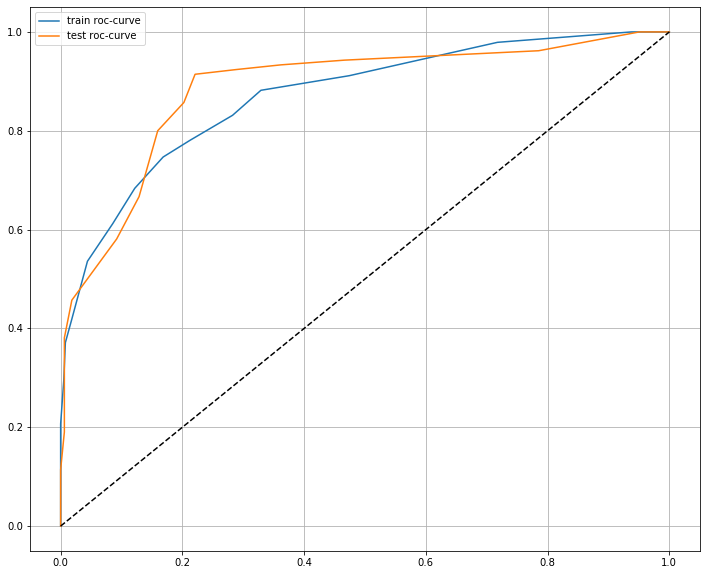

In [64]:
model_research = KNeighborsClassifier(n_neighbors=15, n_jobs=-1).fit(X_train, y_train)
plot_roc_curve(model_research, X_train, X_test, y_train, y_test)

Аналогично _SVC_, для модели _KNeighborsClassifier_ с перебором гиперпараметров немного удалось повысить точность

#### XGBClassifier

В качестве альтернативной модели "Случайного леса" попробуем использовать _XGBClassifier_ из библиотеки _xgboost_, реализующей методы градиентного бустинга

In [66]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    
    """
    alg = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=9,
                        min_child_weight=4, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')

    return alg

In [67]:
alg = xgb_classifier(X_train, X_test, y_train, y_test)

pred_proba_xgb = alg.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba_xgb[:, 1])
print('roc на test', roc_score)


Start Feeding Data
Start Training
roc на test 0.9184633362547473


С помощью _XGBClassifier_ удалось получить весьма неплохой результат

Посмотрим на наиболее важные параметры лучшей модели.

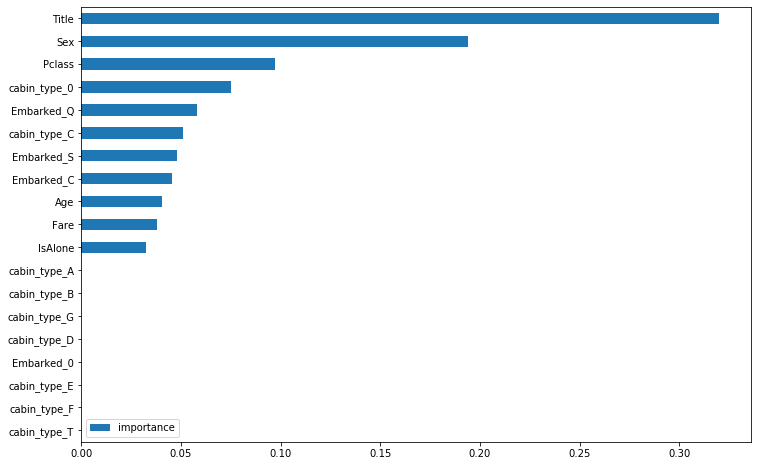

In [68]:
feature_importances = alg.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

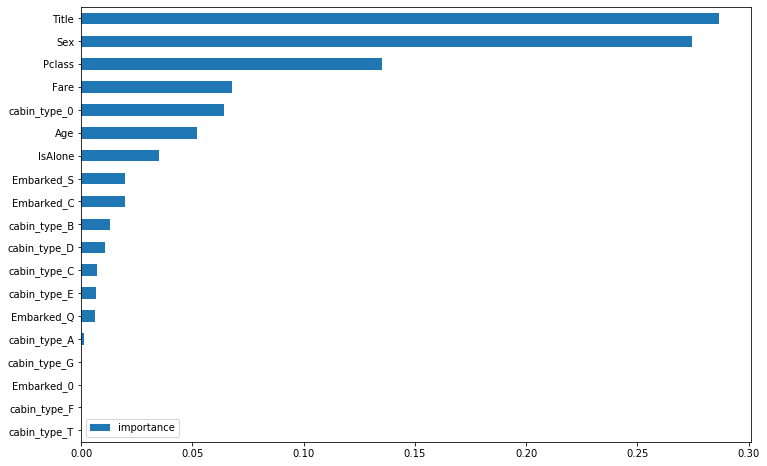

In [69]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

## Результаты моделирования

### Задание 8 (1 балл)
Измерьте качество итоговой модели на кросс-валидации. Выполните предсказание на тестовом множестве и сохраните их в переменную ``y_test``. Измерьте итоговое качество на тестовом множестве.

Качество итоговой (и других) моделей на кросс-валидации, а также качество предсказания на тестовом множестве были выполнены в предыдущих пунктах во время моделирования

RandomForestClassifier

In [70]:
roc_score = roc_auc_score(y_test, pred_proba_rf[:, 1])
roc_score

0.9145778556821501

XGBClassifier

In [71]:
roc_score = roc_auc_score(y_test, pred_proba_xgb[:, 1])
roc_score

0.9184633362547473

In [72]:
Y_pred = best_clf.predict(X_test)

## Выводы
### Задание 9 (3 балла)
Сделайте выводы. Какие из идей сработали? Какие оказались лишними?

* Модели RandomForestClassifier и XGBClassifier показали наилучшие результаты при переборе гиперпараметров 
* Модели KNeighborsClassifier и SVC также показывают неплохой результат
* Решение, учитывающее возраст пассажира с последующим объединением в группы, оказалось удачным
* Можно было бы заранее догадаться, что признак номера каюты (Cabin) не принесёт пользы из-за большого числа пропущенных значений
* Судя по наиболее существенным параметрам (feature_importances), большой вклад приносил новый признак _Title_

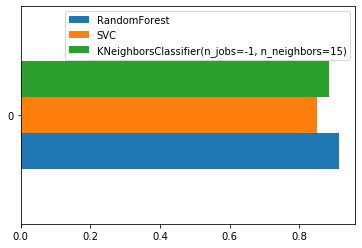

In [103]:
pd.DataFrame([accuracies]).plot(kind='barh')